# Техническое задание

Автор: Кузьмин Дмитрий

## Задание

Анализ паттернов плохо распознаваемых EEG-файлов:

* Анализ качества сырых данных
* Анализ распределения признаков
* Анализ баланса классов
* Анализ предсказаний модели

## Ожидаемые результаты

* Таблица QC-метрик для всех файлов проблемных пациентов
* Графики распределений признаков 
* ROC-кривые для проблемных пацфиентов

In [1]:
import os
import numpy as np
import json
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

## Анализ качества сырых данных

Цель: Выявить проблемы с качеством исходных EEG-записей.

In [2]:
qc_normal_patient = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\analysis\qc_normal_patient.csv')
qc_problem_patient = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\analysis\qc_problem_patient.csv')

In [3]:
qc_normal_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,570.0,570.000000,570.0,570.000000,570.000000
mean,0.0,0.000786,0.0,0.000035,0.001480
std,0.0,0.010886,0.0,0.000017,0.000540
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000024,0.001109
50%,0.0,0.000000,0.0,0.000031,0.001443
75%,0.0,0.000000,0.0,0.000043,0.001743
max,0.0,0.172414,0.0,0.000162,0.003873


In [4]:
qc_problem_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,106.0,106.0,106.0,106.000000,106.000000
mean,0.0,0.0,0.0,0.000015,0.001214
std,0.0,0.0,0.0,0.000006,0.000709
min,0.0,0.0,0.0,0.000009,0.000355
25%,0.0,0.0,0.0,0.000012,0.000742
50%,0.0,0.0,0.0,0.000015,0.001007
75%,0.0,0.0,0.0,0.000017,0.001485
max,0.0,0.0,0.0,0.000058,0.005549


In [5]:
qc_normal_patient['group'] = 'Normal'
qc_problem_patient['group'] = 'Problem'

In [6]:
QC_data = pd.concat([qc_normal_patient, qc_problem_patient], ignore_index=True)
QC_data

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb19,chb19_26.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000015,0.001581,Problem
672,chb19,chb19_27.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000022,0.001159,Problem
673,chb19,chb19_28.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,924672,True,0.0,0.0,[],0.0,0.000032,0.002495,Problem
674,chb19,chb19_29.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000027,0.002391,Problem


In [7]:
file_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\file_index.csv')
seizure_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\seizure_index.csv')

In [8]:
seizure_columns = seizure_index.columns.difference(['patient', 'edf_path', 'sampling_rate'])

files_data = pd.merge(
    file_index, 
    seizure_index[seizure_columns], 
    on='edf_file', 
    how='left'
)

files_data = files_data[files_data['num_seizures'] >= 1]
files_data = files_data.drop(['file_end_time', 'file_start_time', 'seizure_id', 'seizures', 'file_exists'], axis=1)
files_data = files_data[['patient', 'edf_file', 'num_seizures', 'start_time', 'end_time', 'onset_sec', 'offset_sec', 'duration_sec', 'sampling_rate', 'channels']]
files_data

,patient,edf_file,num_seizures,start_time,end_time,onset_sec,offset_sec,duration_sec,sampling_rate,channels
2,chb01,chb01_03.edf,1,13:43:04,14:43:04,2996.0,3036.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
3,chb01,chb01_04.edf,1,14:43:12,15:43:12,1467.0,1494.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
14,chb01,chb01_15.edf,1,01:44:44,2:44:44,1732.0,1772.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
15,chb01,chb01_16.edf,1,02:44:51,3:44:51,1015.0,1066.0,51.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
17,chb01,chb01_18.edf,1,04:45:06,5:45:06,1720.0,1810.0,90.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
...,...,...,...,...,...,...,...,...,...,...
728,chb24,chb24_13.edf,1,NaN,NaN,3288.0,3304.0,16.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
729,chb24,chb24_14.edf,1,NaN,NaN,1939.0,1966.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
730,chb24,chb24_15.edf,1,NaN,NaN,3552.0,3569.0,17.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
731,chb24,chb24_17.edf,1,NaN,NaN,3515.0,3581.0,66.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."


### Датафрейм с QC-метриками и метаданными пациентов

In [9]:
data = pd.merge(
    file_index,  
    QC_data[['patient', 'edf_file', 'nan_ratio', 'flat_ratio', 'flat_channels', 
             'clipped_ratio', 'mean_amplitude', 'max_amplitude', 'group']],
    on=['patient','edf_file'],
    how='left'   
)
data = data.drop(['seizures', 'channels', 'file_exists', 'sampling_rate', 'edf_path'], axis=1)
data

,patient,edf_file,start_time,end_time,num_seizures,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,11:42:54,12:42:54,0,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,12:42:57,13:42:57,0,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,13:43:04,14:43:04,1,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,14:43:12,15:43:12,1,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,15:43:19,16:43:19,0,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb24,chb24_13.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001118,Normal
672,chb24,chb24_14.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000028,0.001254,Normal
673,chb24,chb24_15.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000023,0.001312,Normal
674,chb24,chb24_17.edf,NaN,NaN,1,0.0,0.0,[],0.0,0.000039,0.001504,Normal


In [10]:
data[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,676.0,676.000000,676.0,676.000000,676.000000
mean,0.0,0.000663,0.0,0.000032,0.001439
std,0.0,0.009998,0.0,0.000017,0.000577
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000021,0.001015
50%,0.0,0.000000,0.0,0.000028,0.001373
75%,0.0,0.000000,0.0,0.000040,0.001719
max,0.0,0.172414,0.0,0.000162,0.005549


In [11]:
data[data['flat_ratio'] >= 0.1]

,patient,edf_file,start_time,end_time,num_seizures,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
343,chb12,chb12_27.edf,16:07:06,17:07:06,6,0.0,0.172414,"[3, 9, 13, 19, 23]",0.0,0.000088,0.003124,Normal
344,chb12,chb12_28.edf,17:07:12,18:07:12,1,0.0,0.137931,"[3, 9, 13, 19]",0.0,0.000090,0.001558,Normal
345,chb12,chb12_29.edf,18:07:19,19:07:43,6,0.0,0.137931,"[3, 9, 13, 19]",0.0,0.000125,0.002300,Normal


Метрика flat_ratio показывает долю каналов ЭЭГ, где сигнал является плоским, то есть имеет какие-то артефакты и практически не содержит полезной информаций. У нашего 12 пациента выявлено 13 приступов эпилепсии с flat_ratio > 10%

### Баланс классов до предообработки данных

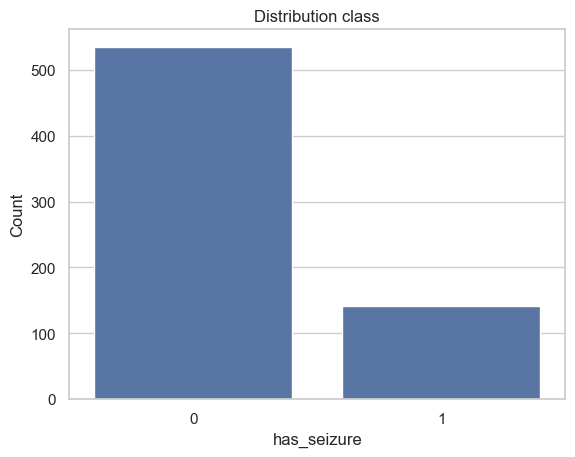

In [12]:
data['has_seizure'] = (data['num_seizures'] >= 1).astype(int)

sns.countplot(data=data, x='has_seizure')
plt.title('Distribution class')
plt.xlabel('has_seizure')
plt.ylabel('Count')

data = data.drop(['has_seizure'], axis=1)

### Графики распределения максимальных и средних амплитуд

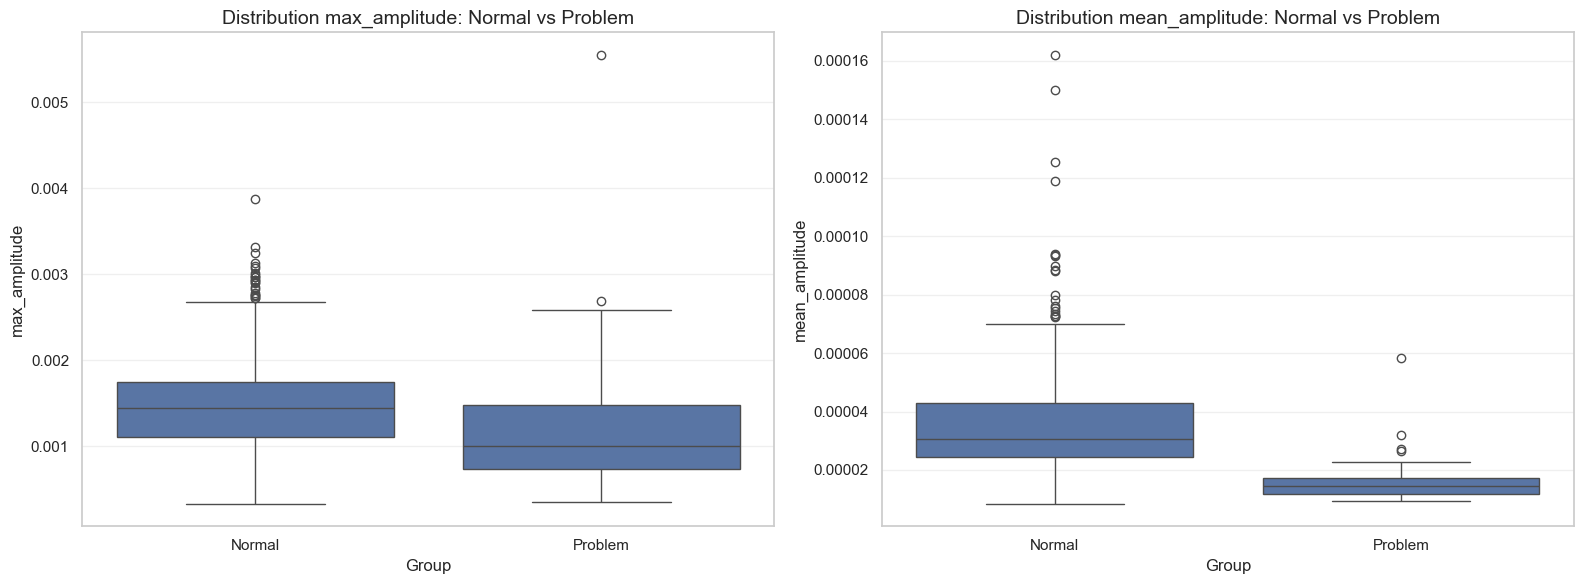

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=data,
    x='group',
    y='max_amplitude',
    ax=axes[0] 
)
axes[0].set_title('Distribution max_amplitude: Normal vs Problem', fontsize=14)
axes[0].set_xlabel('Group')
axes[0].set_ylabel('max_amplitude')
axes[0].grid(axis='y', alpha=0.3)

sns.boxplot(
    data=data,
    x='group',
    y='mean_amplitude',
    ax=axes[1] 
)
axes[1].set_title('Distribution mean_amplitude: Normal vs Problem', fontsize=14)
axes[1].set_xlabel('Group')
axes[1].set_ylabel('mean_amplitude')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Проблемные пациенты демонстрируют сниженные значения как максимальной, так и средней амплитуды ЭЭГ по сравнению с нормальной группой. Медиана средней амплитуды проблемных пациентов в 2 раза ниже, что говорит нам о слишком тихом канале

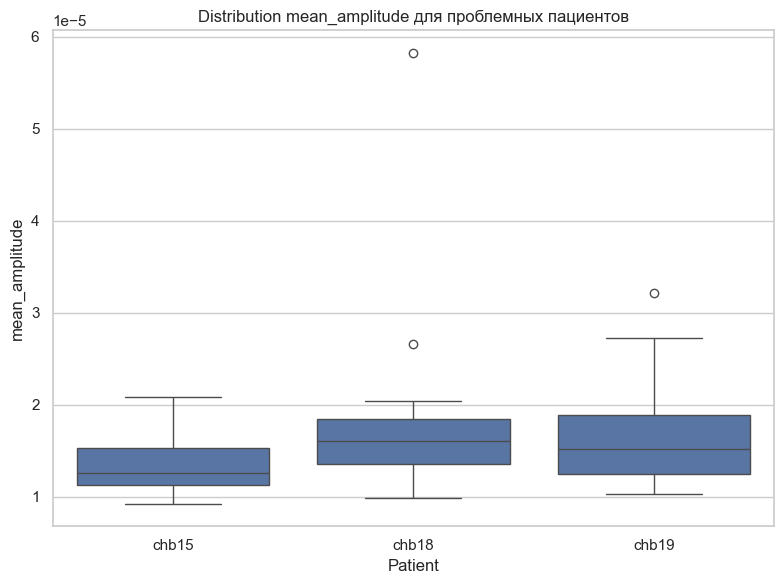

In [14]:
problem_patients = ['chb15', 'chb18', 'chb19']
subset = data[data['patient'].isin(problem_patients)]

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=subset,
    x='patient',
    y='mean_amplitude'
)

plt.title('Distribution mean_amplitude для проблемных пациентов')
plt.xlabel('Patient')
plt.ylabel('mean_amplitude')
plt.tight_layout()
plt.show()

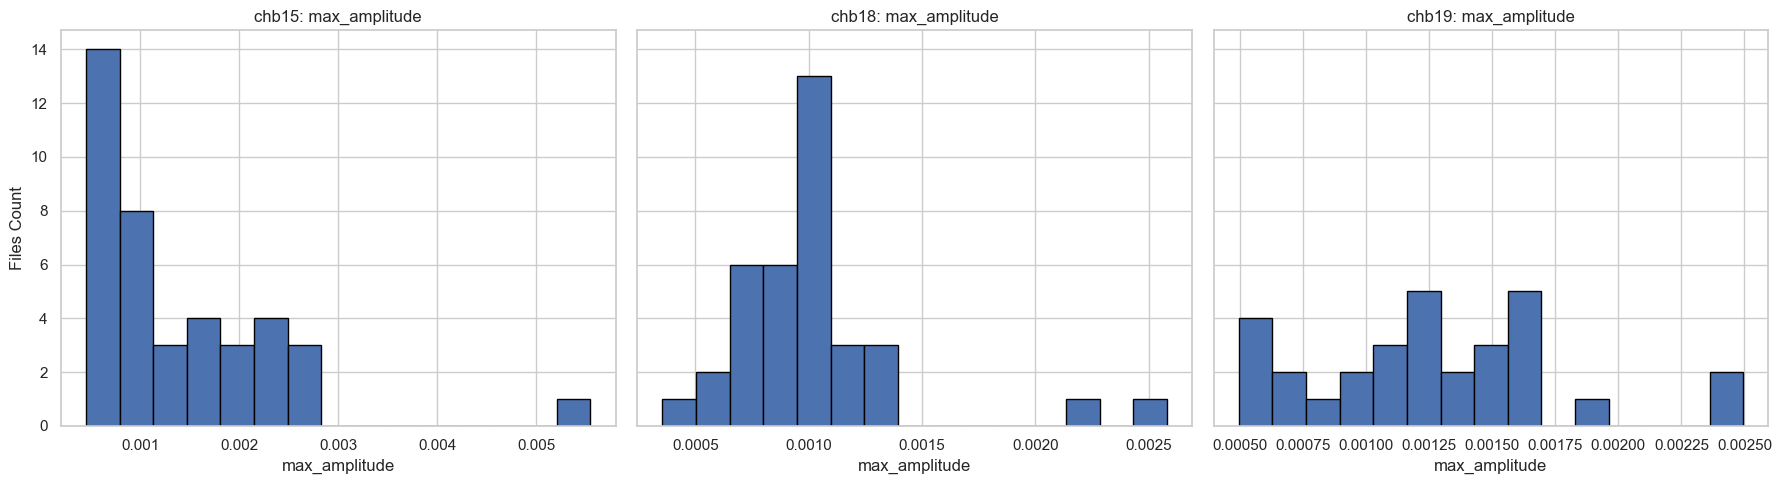

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, patient in zip(axes, ['chb15', 'chb18', 'chb19']):
    subset = data[data['patient'] == patient]
    ax.hist(subset['max_amplitude'], bins=15, edgecolor='black')
    ax.set_title(f'{patient}: max_amplitude')
    ax.set_xlabel('max_amplitude')
axes[0].set_ylabel('Files Count')
plt.tight_layout()
plt.show()

Все три пациента имеют низкоамплитудные сигналы:

* chb15 - сильно смещенное распределение влево, где есть выброс с аномальной амплитудой
* chb18 - амплитуда имеет более менее хорошее распределение, но является все также низкой
* chb19 - тут у нас 3 файла записи (seizures), амплитуда имеет бимодальной распределение с 2-умя пиками, возможно, припадок локализован в электроде T8-P8, который отсуствовал при записи данных, что влияет на амплитуду сигнала

если эпилептическая активность у проблемных пациентов расположена в правой височной области, отсутствие T8-P8 канала может критически влиять на качество предсказания припадков

## Анализ распределения признаков

Цель: Сравнить распределения признаков между успешными и проблемными пациентами.

Группы признаков:

*	PSD bands (delta, theta, alpha, beta, gamma) — спектральная мощность
*	Relative power — относительная мощность по диапазонам
*	Statistical (mean, std, skewness, kurtosis) — статистические признаки
*	Hjorth (activity, mobility, complexity) — параметры Хьорта
*	Temporal (line_length, energy) — временные признаки

In [16]:
base_dir = r'C:\Users\_\Desktop\IT\epilepsy\outputs'
meta_cols = ['patient', 'edf_file', 't_start', 't_end', 'label', 'seizure_id']
psd = ['delta', 'theta', 'alpha', 'beta', 'gamma']
stat_features = ['mean', 'std', 'skewness', 'kurtosis', 'line_length', 'energy']
hjorth_features = ['activity', 'mobility', 'complexity']
problem_features_dict = {}

### Обработка данных и создание общего фрейма

In [17]:
all_files = []

for patient in os.listdir(base_dir):
    patient_dir = os.path.join(base_dir, patient)
    if not os.path.isdir(patient_dir): 
        continue
    
    for file in os.listdir(patient_dir):
        if file.endswith('_features.csv'):
            csv_path = os.path.join(patient_dir, file)
            features = pd.read_csv(csv_path)
            
            feature_cols = [c for c in features.columns if c not in meta_cols]
            n_features = len(feature_cols)
            n_channels = n_features // 19 
            
            feature_names = []
            for ch in range(n_channels):
                for band in psd:
                    feature_names.append(f'ch{ch}_psd_{band}')
                for band in psd:
                    feature_names.append(f'ch{ch}_rel_{band}')
                for stat in stat_features:
                    feature_names.append(f'ch{ch}_{stat}')
                for hj in hjorth_features:
                    feature_names.append(f'ch{ch}_hjorth_{hj}')
            
            rename_map = {old: new for old, new in zip(feature_cols, feature_names)}
            features_renamed = features.rename(columns=rename_map)
            
            agg_df = pd.DataFrame()
            agg_df[meta_cols] = features_renamed[meta_cols]
            
            for band in psd:
                cols = [c for c in features_renamed.columns if c.endswith(f'psd_{band}')]
                agg_df[f'psd_{band}'] = features_renamed[cols].mean(axis=1)
            
            for band in psd:
                cols = [c for c in features_renamed.columns if c.endswith(f'rel_{band}')]
                agg_df[f'rel_{band}'] = features_renamed[cols].mean(axis=1)
                
            for stat in ['mean', 'std', 'skewness', 'kurtosis', 'line_length', 'energy']:
                cols = [c for c in features_renamed.columns if c.endswith(f'_{stat}')]
                if cols:
                    agg_df[stat] = features_renamed[cols].mean(axis=1)
            
            for hj in hjorth_features:
                cols = features_renamed.filter(regex=rf'ch\d+_hjorth_{hj}$')
                if not cols.empty:
                    agg_df[f'hjorth_{hj}'] = cols.mean(axis=1)
                else:
                    agg_df[f'hjorth_{hj}'] = pd.NA
            all_files.append(agg_df)

full_dataset = pd.concat(all_files, ignore_index=True)
print(f"Загружено {len(full_dataset)} записей из {len(all_files)} файлов")
full_dataset.head()

Загружено 1504909 записей из 24 файлов


,patient,edf_file,t_start,t_end,label,seizure_id,psd_delta,psd_theta,psd_alpha,psd_beta,...,rel_gamma,mean,std,skewness,kurtosis,line_length,energy,hjorth_activity,hjorth_mobility,hjorth_complexity
0,chb01,chb01_01.edf,0.0,4.0,0,0,0.065180,0.195096,-0.011274,0.187322,...,0.056459,0.103349,0.128790,0.146462,0.295572,0.237765,0.118171,0.143723,0.199723,0.105480
1,chb01,chb01_01.edf,2.0,6.0,0,0,0.066336,0.160668,0.237865,0.195768,...,0.045396,0.112273,0.163819,0.174816,0.299302,0.231375,0.107944,0.148329,0.297803,0.140607
2,chb01,chb01_01.edf,4.0,8.0,0,0,0.060011,0.205286,0.407936,0.320837,...,0.083926,0.077113,0.202469,0.198263,0.220986,0.184273,0.085675,-0.021958,0.356657,0.094151
3,chb01,chb01_01.edf,6.0,10.0,0,0,0.200223,0.323349,0.263649,0.116264,...,0.138493,0.201337,0.191072,0.392039,0.555215,0.116565,0.120147,0.273154,0.500876,0.117263
4,chb01,chb01_01.edf,8.0,12.0,0,0,0.051178,0.504676,0.321527,0.082309,...,0.001712,0.236557,0.679028,0.905978,0.510916,0.327609,0.118726,0.344930,0.563547,0.046247


Для анализа признаков я использовал функцию извлечения признаков после пердообработки данных, где шаг окна был равен 2-ух секундом, что повлияло на количество строк в датасете (1.5млн). Из-за этого построение графиков баланса классов может наблюдаться экстримальный баланс целевой переменной

### Пропущенные значения

In [18]:
full_dataset.isna().sum()

patient              0
edf_file             0
t_start              0
t_end                0
label                0
seizure_id           0
psd_delta            0
psd_theta            0
psd_alpha            0
psd_beta             0
psd_gamma            0
rel_delta            0
rel_theta            0
rel_alpha            0
rel_beta             0
rel_gamma            0
mean                 0
std                  0
skewness             0
kurtosis             0
line_length          0
energy               0
hjorth_activity      0
hjorth_mobility      0
hjorth_complexity    0
dtype: int64

### Датасет для анализа данных

В моем фрейме 25 колонок из которых 6 колонок с метаданными файлов, а другие 19 с осноовными метриками. Метрики я усреднил по всем каналам, а не по отдельности, поэтому дальнейший анализ является поверхностным, который позволит нам познакомиться с данными. Для глубины можно усреднить по отдельному каналу и более детально изучить поведение в T8-P8, а также в других каналх и найти еще больше гипотез

In [19]:
data = pd.merge(full_dataset, data[['patient', 'edf_file', 'group']], on=['patient', 'edf_file'], how='left')

normal_features = data[data['group'] == 'Normal']
problem_features = data[data['group'] == 'Problem']

data = pd.concat([normal_features, problem_features], ignore_index=True)
data

,patient,edf_file,t_start,t_end,label,seizure_id,psd_delta,psd_theta,psd_alpha,psd_beta,...,mean,std,skewness,kurtosis,line_length,energy,hjorth_activity,hjorth_mobility,hjorth_complexity,group
0,chb01,chb01_01.edf,0.0,4.0,0,0,0.065180,0.195096,-0.011274,0.187322,...,0.103349,0.128790,0.146462,0.295572,0.237765,0.118171,0.143723,0.199723,0.105480,Normal
1,chb01,chb01_01.edf,2.0,6.0,0,0,0.066336,0.160668,0.237865,0.195768,...,0.112273,0.163819,0.174816,0.299302,0.231375,0.107944,0.148329,0.297803,0.140607,Normal
2,chb01,chb01_01.edf,4.0,8.0,0,0,0.060011,0.205286,0.407936,0.320837,...,0.077113,0.202469,0.198263,0.220986,0.184273,0.085675,-0.021958,0.356657,0.094151,Normal
3,chb01,chb01_01.edf,6.0,10.0,0,0,0.200223,0.323349,0.263649,0.116264,...,0.201337,0.191072,0.392039,0.555215,0.116565,0.120147,0.273154,0.500876,0.117263,Normal
4,chb01,chb01_01.edf,8.0,12.0,0,0,0.051178,0.504676,0.321527,0.082309,...,0.236557,0.679028,0.905978,0.510916,0.327609,0.118726,0.344930,0.563547,0.046247,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504904,chb19,chb19_30.edf,3086.0,3090.0,1,3,0.046383,0.070338,0.153198,0.132406,...,0.015113,0.073409,0.092771,0.113467,0.113990,0.098575,0.165437,0.147808,0.088423,Problem
1504905,chb19,chb19_30.edf,3088.0,3092.0,1,3,0.023220,0.063080,0.104737,0.075053,...,0.004804,0.063949,0.171761,0.061841,0.121665,0.019898,0.069908,0.073842,0.044663,Problem
1504906,chb19,chb19_30.edf,3090.0,3094.0,1,3,0.448527,0.150360,0.807040,0.604524,...,0.314170,0.272108,0.679389,0.729827,0.481775,0.008078,0.575663,0.327953,0.604027,Problem
1504907,chb19,chb19_30.edf,3092.0,3096.0,1,3,0.071245,0.163294,0.174885,0.136673,...,0.098360,0.069654,0.097520,0.151948,0.091270,0.025258,0.172566,0.162137,0.106792,Problem


In [20]:
psd_features = ['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma']
stat_features = ['mean', 'std', 'skewness', 'kurtosis', 'line_length', 'energy']
hjorth_params = ['hjorth_activity', 'hjorth_mobility', 'hjorth_complexity']

normal_data = data[data['group'] == 'Normal']
problem_data = data[data['group'] == 'Problem']

print(f"Normal patients: {normal_data['patient'].nunique()} пациентов, {len(normal_data)} записей")
print(f"Problem patients: {problem_data['patient'].nunique()} пациентов, {len(problem_data)} записей")

Normal patients: 21 пациентов, 1343111 записей
Problem patients: 3 пациентов, 161798 записей


### PSD Features

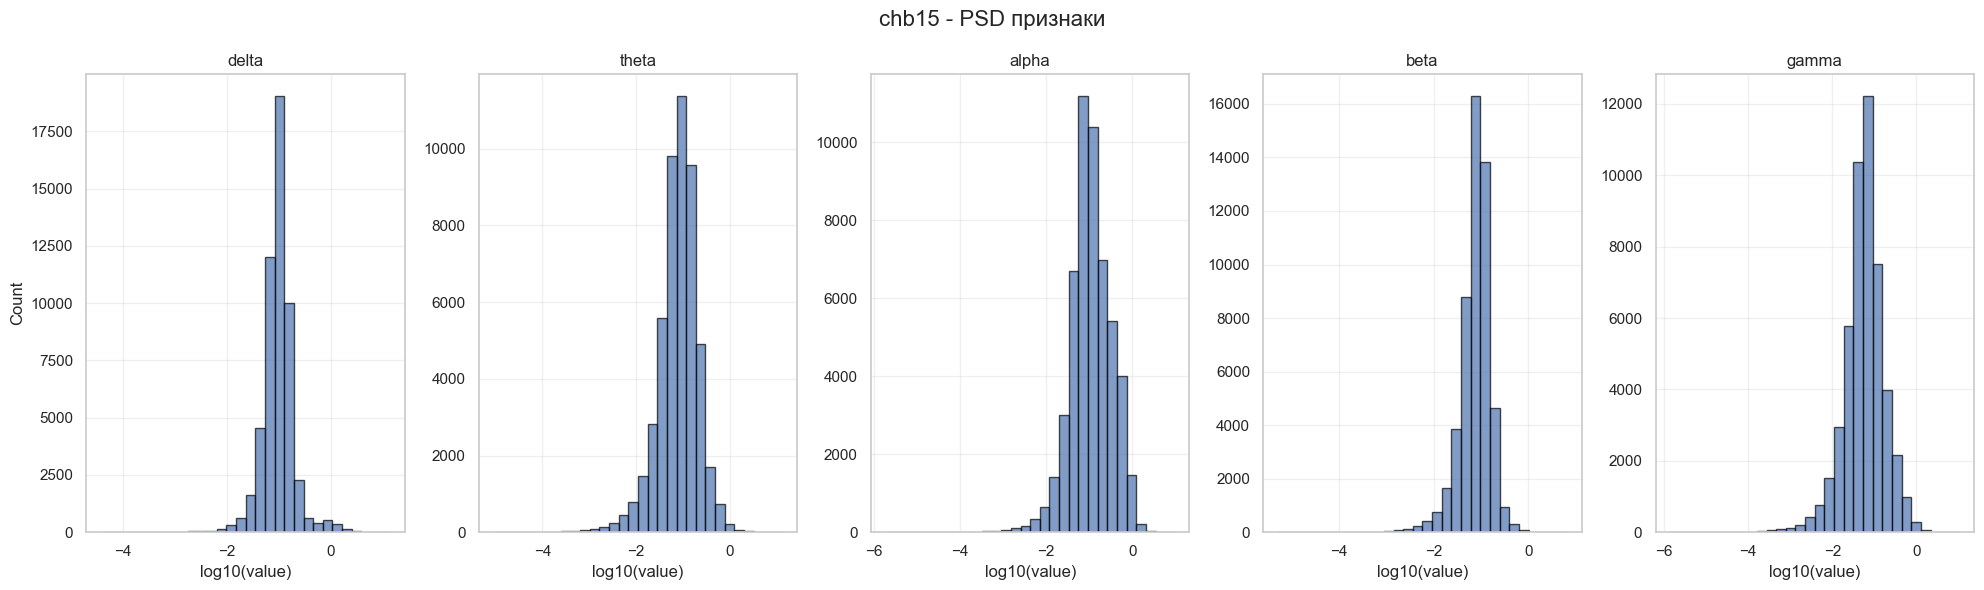

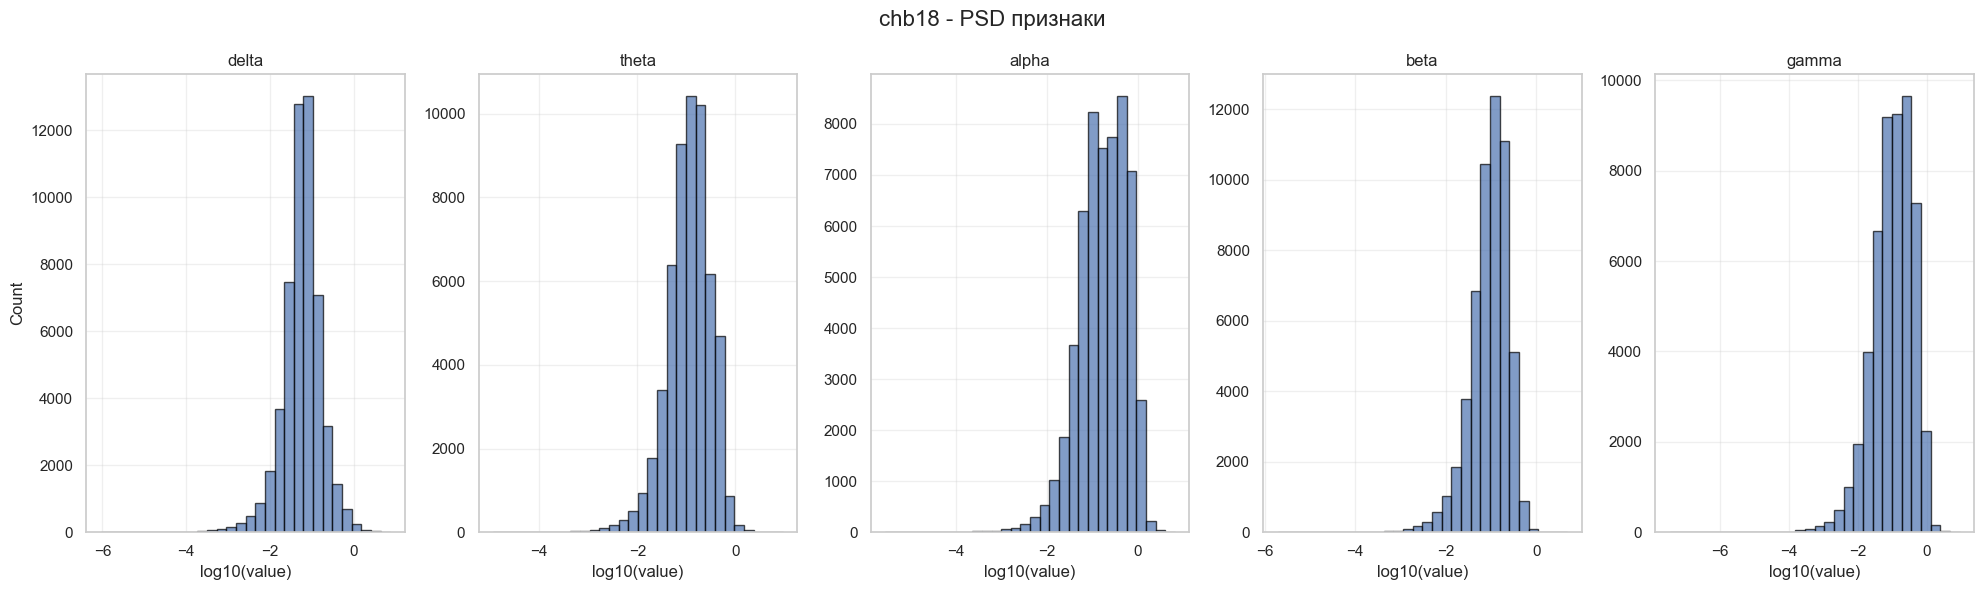

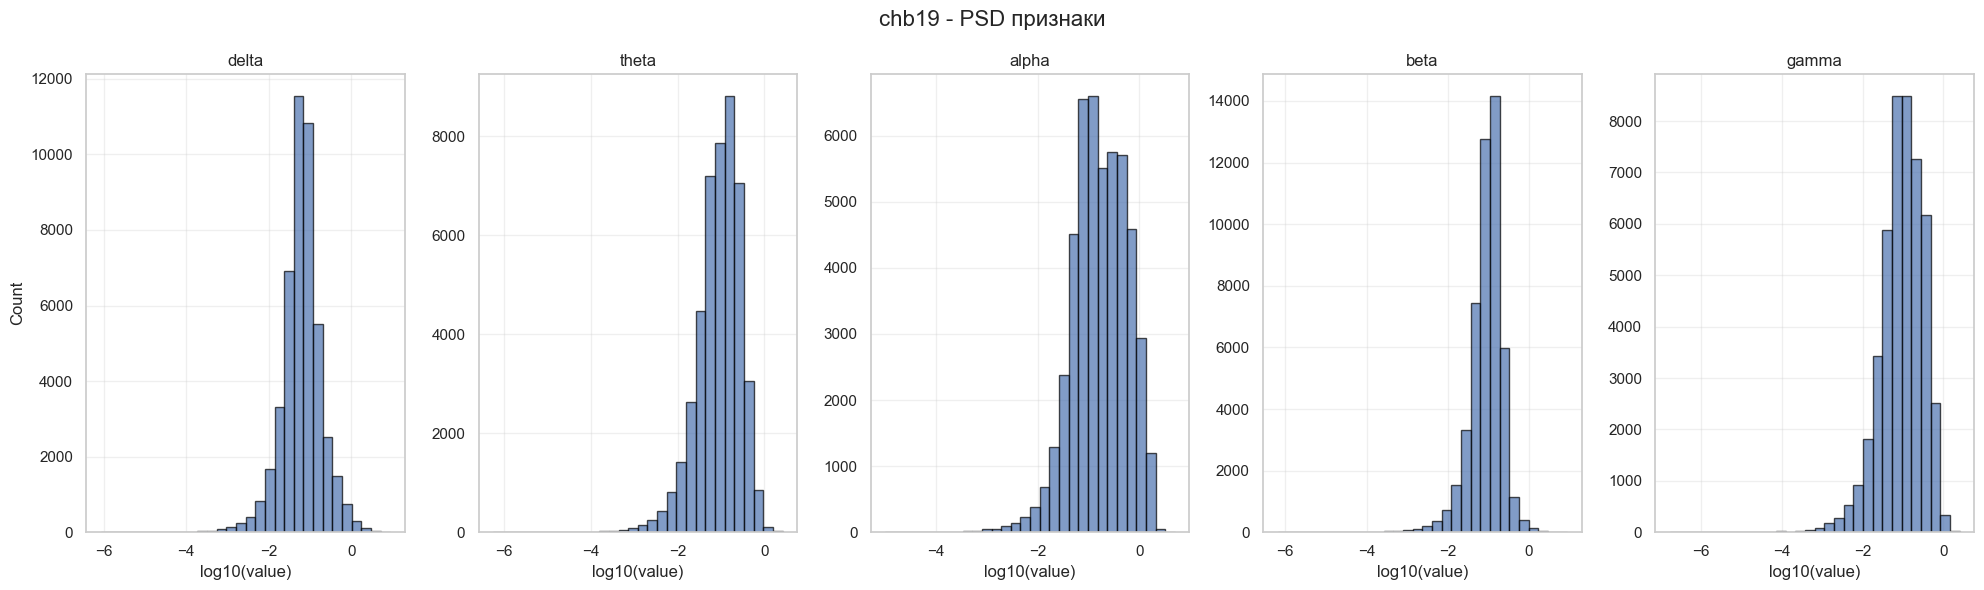

In [21]:
groups = [
    ('chb15', problem_data[problem_data['patient'] == 'chb15']),
    ('chb18', problem_data[problem_data['patient'] == 'chb18']),
    ('chb19', problem_data[problem_data['patient'] == 'chb19'])
]

for name, df in groups:
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    fig.suptitle(f'{name} - PSD признаки', fontsize=16)
    
    for i, f in enumerate(psd_features):
        vals = df[f].dropna()
        vals_log = np.log10(vals[vals > 0])
        if len(vals_log) > 0:
            axes[i].hist(vals_log, bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f.replace('psd_', ''))
            axes[i].set_xlabel('log10(value)')
            axes[i].grid(alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
    
    axes[0].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

По графикам видно, что у проблемных пациентов распределения по диапазонам схожи, но есть небольшие систематические сдвиги по оси Х. У chb19 более низкие PSD-значения из-за малого количества файлов, chb15 - более высокие. Если обучать без техник нормализаций, то можно переобучить модель на chb15 и ошибаться на chb19, потому что его сигналы более тихие по сравнению с chb15

###  Hjorth Features 

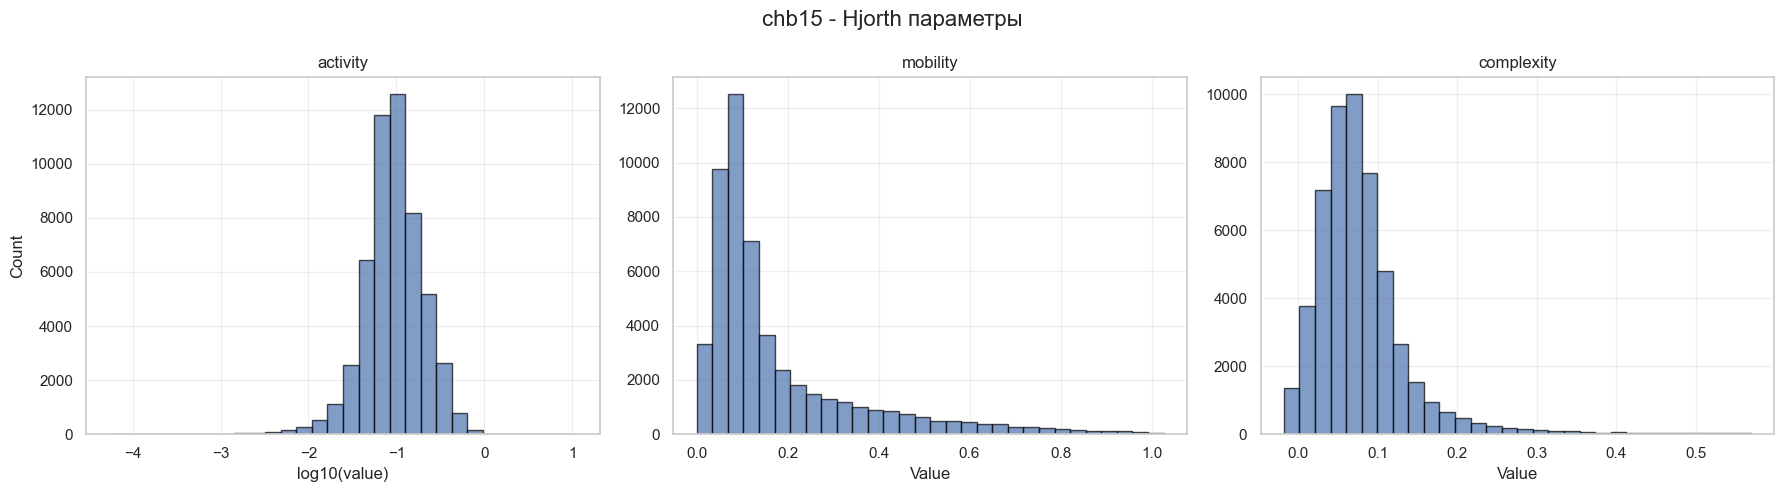

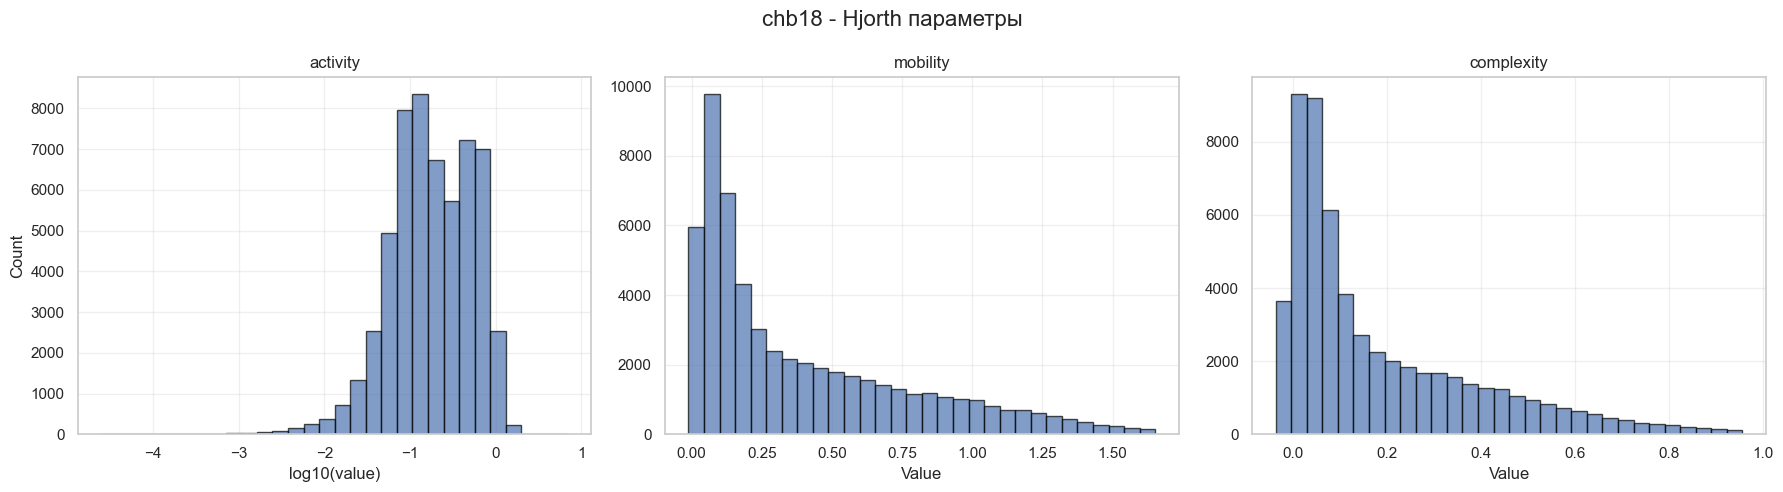

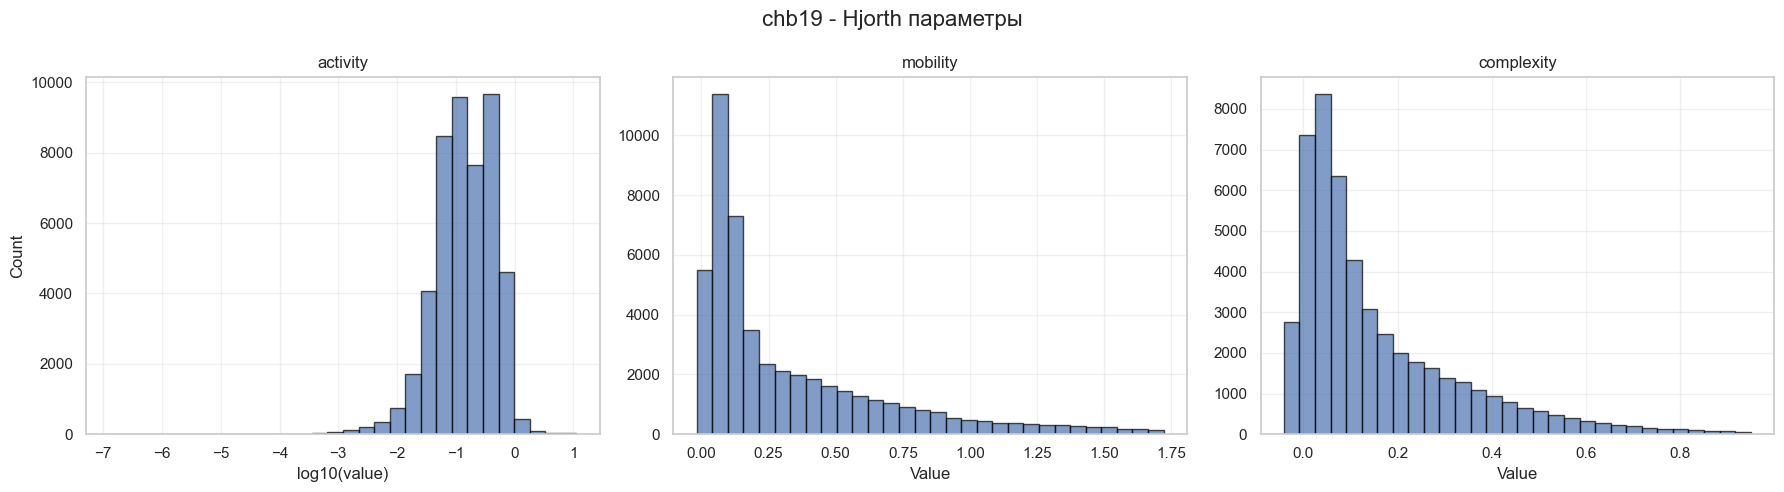

In [22]:
groups = [
    ('chb15', problem_data[problem_data['patient'] == 'chb15']),
    ('chb18', problem_data[problem_data['patient'] == 'chb18']),
    ('chb19', problem_data[problem_data['patient'] == 'chb19'])
]

for name, df in groups:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{name} - Hjorth параметры', fontsize=16)
    
    for i, f in enumerate(hjorth_params):
        vals = df[f].dropna()
        if len(vals) > 0:
            if f == 'hjorth_activity':
                vals = np.log10(vals[vals > 0])
                axes[i].set_xlabel('log10(value)')
            else:
                lo, hi = np.percentile(vals, [1, 99])
                vals = vals[(vals >= lo) & (vals <= hi)]
                axes[i].set_xlabel('Value')
            axes[i].hist(vals, bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f.replace('hjorth_', ''))
            axes[i].grid(alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f.replace('hjorth_', ''))
    
    axes[0].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

Для каждого пациента построены гистограммы трёх параметров Хьорта:

* activity — логарифм мощности сигнала 
* mobility — «подвижность», отношение среднеквадратичной скорости к амплитуде
* complexity — «сложность», насколько форма сигнала отличается от синусоиды

У chb15 распределение всех параметров смещены к более высоким значения, то есть этот пациент содержит больше быстрых изменений и обладает более сложной структурой

У chb18 все параметры занимают промежуточное положение. Можно считать, что chb18 обладает умеренной активностью и все норм

У chb19 распределние больше похоже на chb18 в отличии от chb15

### Statistical Features

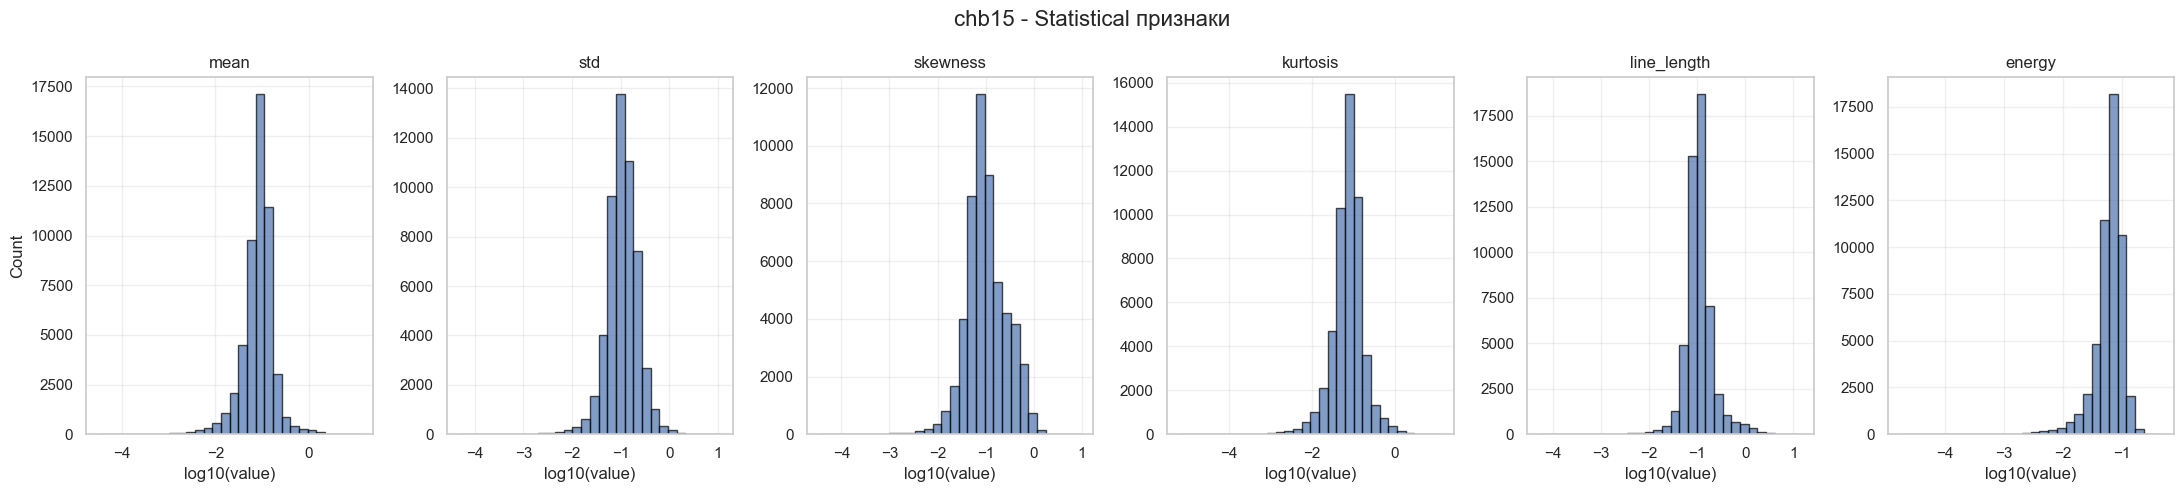

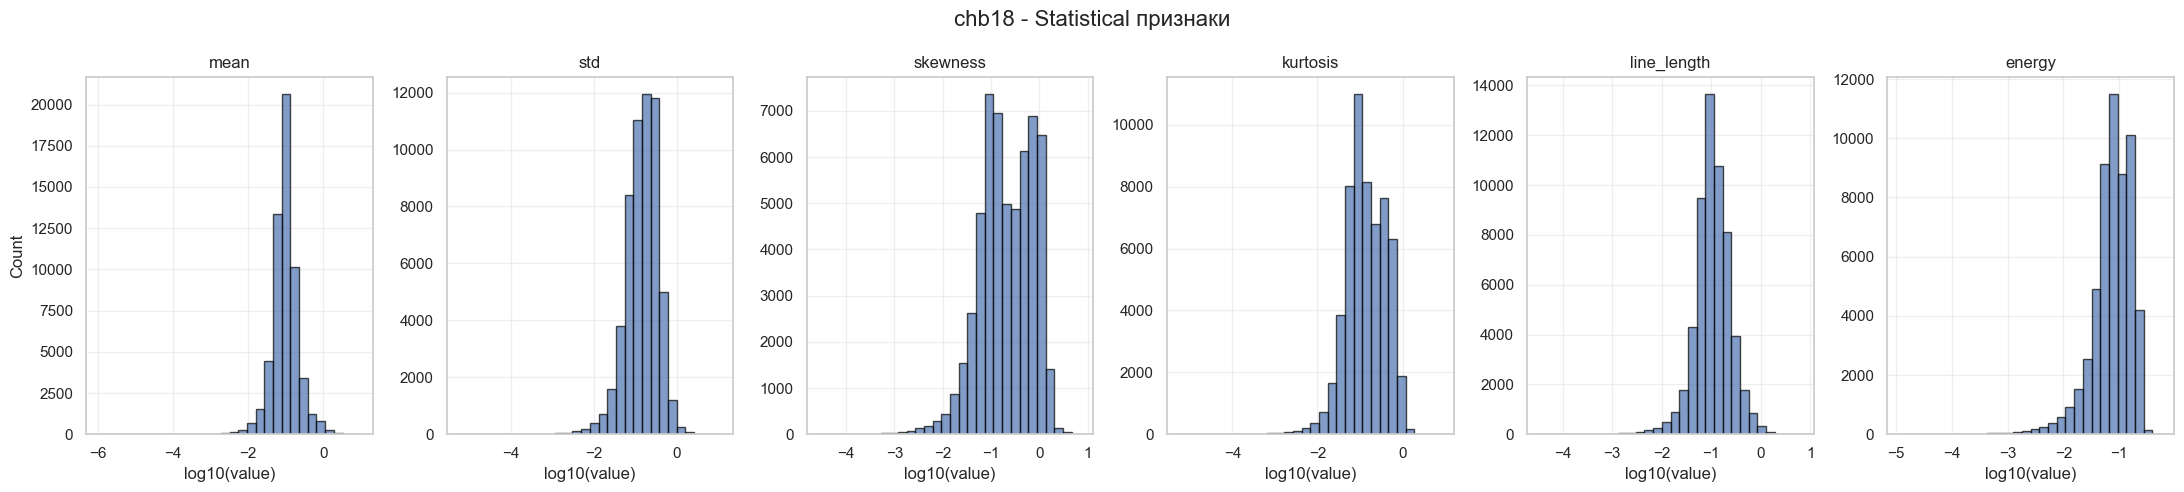

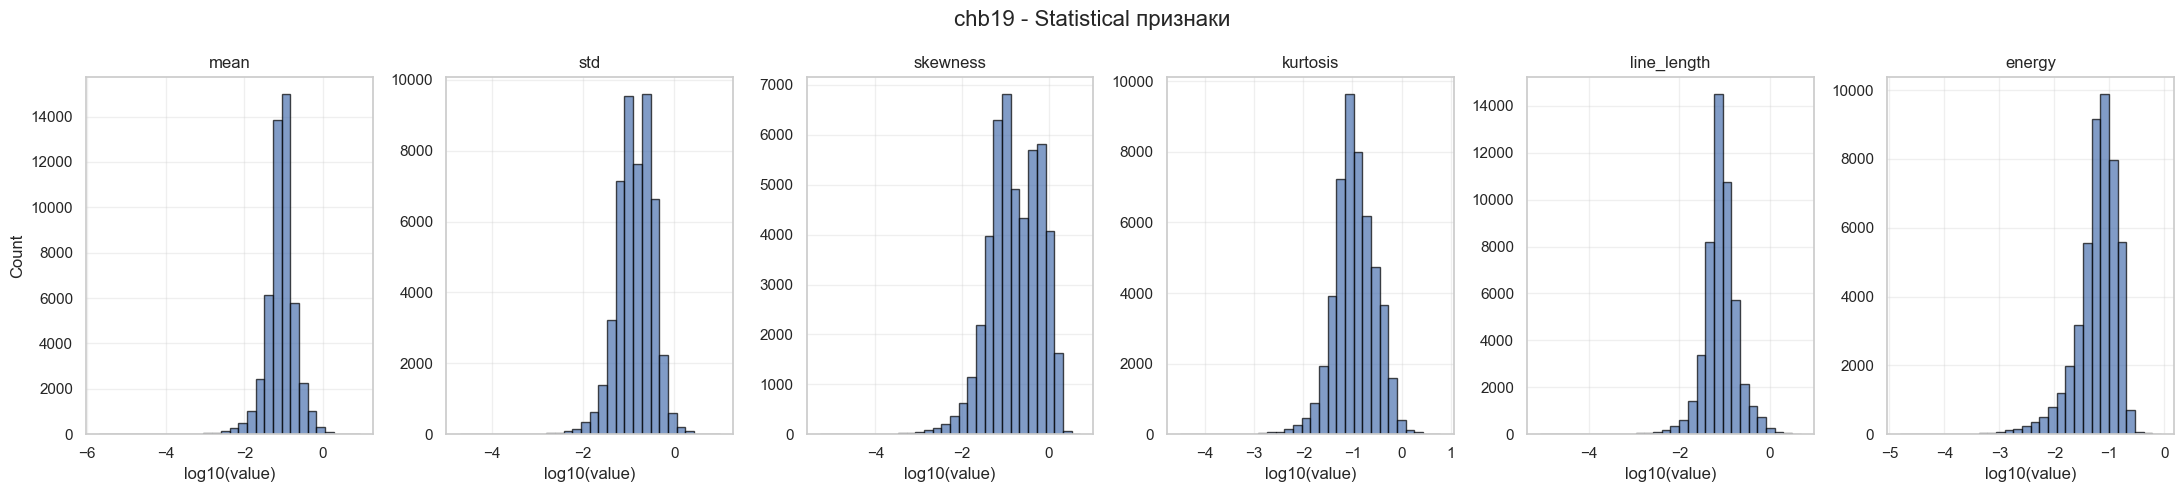

In [23]:
for name, df in groups:
    fig, axes = plt.subplots(1, 6, figsize=(22, 5))
    fig.suptitle(f'{name} - Statistical признаки', fontsize=16)
    
    for i, f in enumerate(stat_features):
        vals = df[f].dropna()
        vals_log = np.log10(vals[vals > 0])
        if len(vals_log) > 0:
            axes[i].hist(vals_log, bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f)
            axes[i].set_xlabel('log10(value)')
            axes[i].grid(alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
    
    axes[0].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

ну тут тоже самое: chb19 - слабые и тихие признаки, chb15 - сильные и грмокие, а chb18 что-то между ними

## Анализ баланса классов (preictal / interictal)

Цель: Проверить корректность разметки и баланса классов

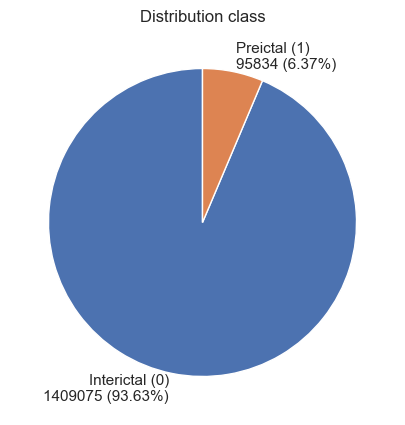

In [24]:
counts = data['label'].value_counts().sort_index()
total = counts.sum()
plt.figure(figsize=(8, 5))
plt.pie(
    counts,
    labels=[f'Interictal (0)\n{counts[0]} ({counts[0]/total:.2%})',
            f'Preictal (1)\n{counts[1]} ({counts[1]/total:.2%})'], startangle=90)
plt.title('Distribution class')
plt.show()

При обучение на 2-ух окнах у нас имеется экстримальный дисбаланс классов <10%

## Анализ метрик обучения

In [40]:
metrics_root = Path("..") / "outputs" / "transfer_learning"

rows = []

for patient_dir in sorted(metrics_root.iterdir()):
    if not patient_dir.is_dir():
        continue
    patient_id = patient_dir.name
    metrics_path = patient_dir / "metrics_dl.json"
    if not metrics_path.exists():
        continue 
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    row = {"patient": patient_id}
    row.update(metrics)
    rows.append(row)
metrics_df = pd.DataFrame(rows).sort_values("patient").reset_index(drop=True)
print(f' Среднее значение sensitivity: {round(metrics_df['sensitivity'].mean(), 4)}')
metrics_df

 Среднее значение sensitivity: 0.9093


,patient,sensitivity,n_detected,n_seizures,n_alarms,fa_per_24h,total_hours,optimal_threshold,threshold_f1
0,chb01,1.000000,7,7,1,0.0,36.505556,0.1,0.133875
1,chb02,1.000000,3,3,1,0.0,33.966667,0.1,0.056364
2,chb03,1.000000,7,7,1,0.0,33.267778,0.1,0.128454
3,chb04,1.000000,4,4,1,0.0,146.840556,0.1,0.019608
4,chb05,1.000000,5,5,1,0.0,35.815556,0.1,0.097307
5,chb06,1.000000,10,10,1,0.0,44.873889,0.1,0.165126
6,chb07,1.000000,3,3,1,0.0,59.454444,0.1,0.047598
7,chb08,1.000000,5,5,1,0.0,17.413333,0.1,0.243640
8,chb09,1.000000,4,4,1,0.0,60.209444,0.1,0.062170
9,chb10,1.000000,7,7,1,0.0,39.260556,0.1,0.153555


In [41]:
metrics_df[metrics_df['patient'].isin(problem_patients)]

,patient,sensitivity,n_detected,n_seizures,n_alarms,fa_per_24h,total_hours,optimal_threshold,threshold_f1
14,chb15,0.7,14,20,1,0.0,29.708889,0.1,0.222710
17,chb18,1.0,6,6,1,0.0,32.162222,0.1,0.126745
18,chb19,1.0,3,3,1,0.0,28.016667,0.1,0.071031


Наша модель успешно обучилась на наших проблемных пациентов и продемонстрировала хорошие результаты

In [46]:
metrics_df[metrics_df['sensitivity'] < 0.71]

,patient,sensitivity,n_detected,n_seizures,n_alarms,fa_per_24h,total_hours,optimal_threshold,threshold_f1
11,chb12,0.475,19,40,1,0.0,14.025556,0.1,0.355042
14,chb15,0.700,14,20,1,0.0,29.708889,0.1,0.222710
15,chb16,0.600,6,10,1,0.0,14.775556,0.1,0.215333


Данные пациенты показали не очень хорошие результаты. 

- У chb12 мы знаем, что 13 приступов были с flat_ratio > 10%, поэтому при обучении мы можем просто их удалить
- у chb15 мы знаем, что его сигналы имеют богатый характер, то есть они громкие и может быть зашумленные, можно будет их нормализовать
- у chb16 мы пока ничего не знаем, поэтому нужно будет исследовать этого пациента

## Вывод анализа

В ходе анализа сырых данных было выявлено 13 приступов у пациента chb12 с повышенными значениями QC-метрики flat_ratio, что указывает на наличие проблемных участков в сырых записях. Для проблемных пациентов были построены визуализации средней и максимальной амплитуды сигналов. Анализ показал, что у проблемных пациентов амплитуды в среднем примерно в 2 раза ниже, чем медианное значение у нормальных пациентов, что может негативно влиять на качество обучения модели

При анализе распределения признаков было обработано около 1,5 млн усреднённых по каналам признаков, извлечённых из 24 файлов. Каждая строка соответствовала окну длительностью 2 секунды.

Для проблемных пациентов были построены графики распределения признаков по файлам. В целом распределения по диапазонам оказались схожими, однако у пациента chb15 наблюдались более высокие значения признаков, что связано с большим количеством данных и более выраженной активностью сигналов по сравнению с chb18 и chb19

После обучения модель показала хорошие результаты на проблемных пациентах. Для пациентов chb18 и chb19 была достигнута чувствительность 100%, а для chb15 — 70%, при этом количество ложных срабатываний оставалось минимальным

Важно отметить, что на данном этапе файлы с повышенным значением QC-метрики flat_ratio (>10%) не исключались из обучающей выборки, поэтому для пациента chb12 чувствительность модели составила 47.5%